__TODO: Check which channel need to be kept (green, or PCA of channels, or directly RBG to Grayscale__

# Import librairies

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "/appli")
import cv2

plt.rcParams["figure.figsize"] = (15, 15)
from utile.pre_processing import PreProcessingPipeline

# Loading data

In [2]:
# Import train data
img_path = "../kaggle_dataset"
train_df = pd.read_csv("data/train.csv")
# Create the path of the image in the dataframe
train_df["path"] = train_df.apply(
    lambda x: "".join(
        [img_path, "/", str(x["patient_id"]), "_", str(x["image_id"]), ".png"]
    ),
    axis=1,
)

In [3]:
examples_list = [
    "1450_1185608765",
    "294_2044098614",
    "1461_1322198700",
    "1511_764545189",
    "1468_893864802",
    "1475_86778676",
    "1479_1933359921",
    "1493_1074894518",
    "1499_14130510",
    "1499_1988370728",
    "1511_764545189",
    "1511_1031853445",
    "1550_1451929890",
    "1653_1271242363",
    "1660_135787921",
    "1701_1613351630",
    "1719_138770970",
    "1878_1490758028",
    "1899_540562039",
    "65525_751035345",
    "393_1702011739",  # Problem ultra bright zone
    "1939_841837846",  # Whole breast super bright
    "65456_247536669",  # Some ultra bright zone
    "65271_171953953",  # Label to remove
    "38739_1189630231",
    "1511_1273092690",
    "1511_1031853445",
]

examples_list_path = [
    "".join([img_path, "/", x.split("_")[0], "_", x.split("_")[1], ".png"])
    for x in examples_list
]

In [4]:
Pipeline = PreProcessingPipeline()

# Artefact removal

Works for both annotation's labels, vertical lines if not interescts with brest

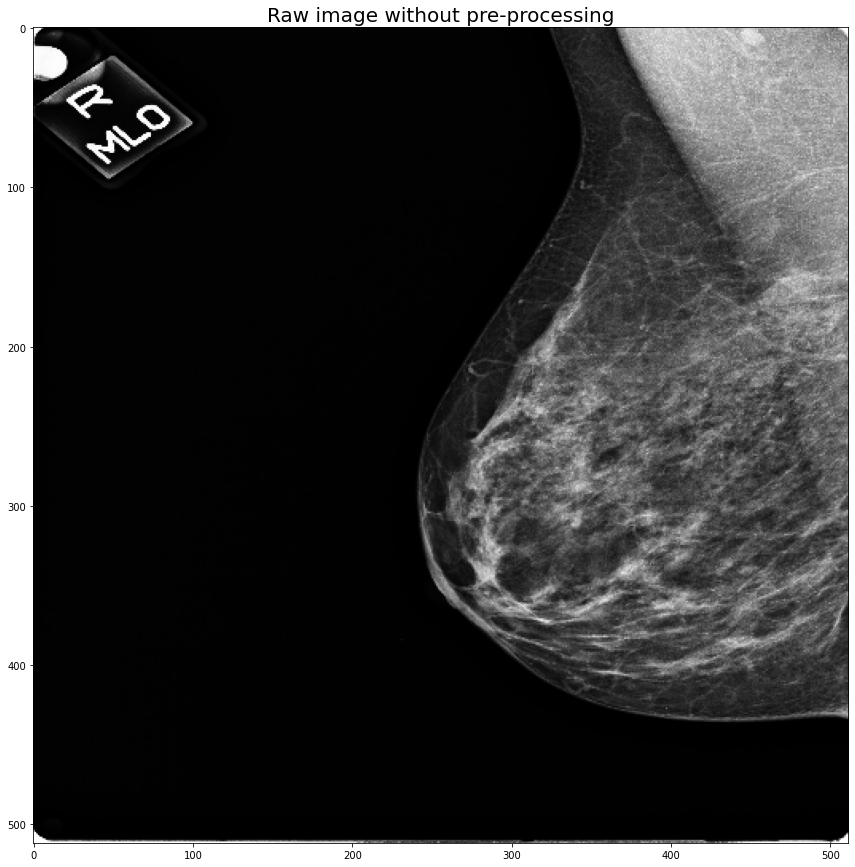

In [5]:
image = cv2.imread(examples_list_path[18])  # 10
plt.imshow(image, cmap="gray")
plt.title("Raw image without pre-processing", fontsize=20)
plt.show()

In [6]:
image = Pipeline._to_gray(image)

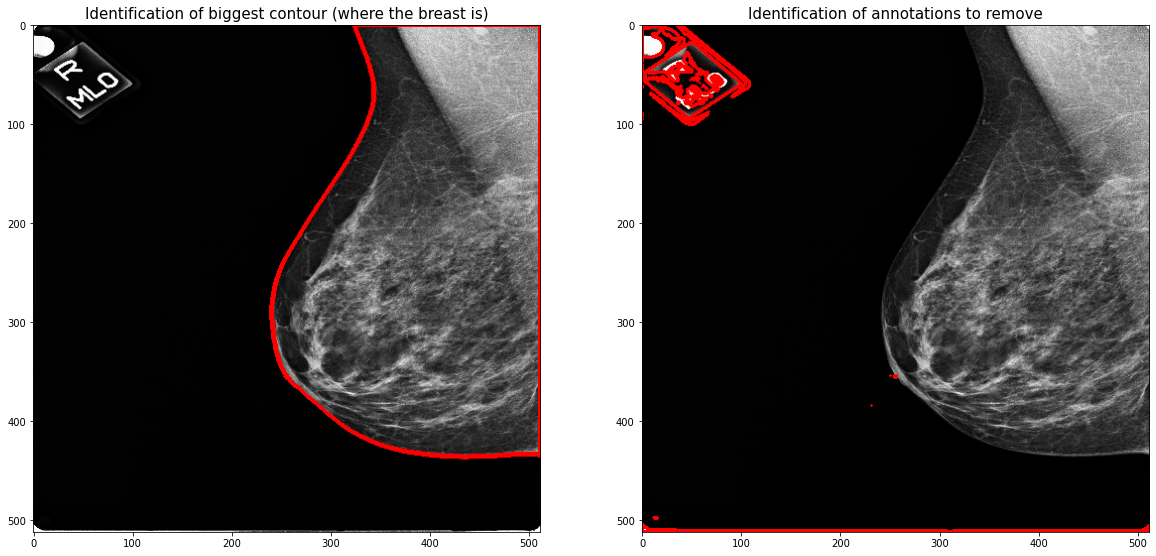

In [7]:
contours = Pipeline.get_contours(image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(Pipeline.draw_contours(contours, image, biggest=True)[0])
ax1.set_title("Identification of biggest contour (where the breast is)", fontsize=15)
ax2.imshow(Pipeline.draw_contours(contours, image, biggest=False)[0])
ax2.set_title("Identification of annotations to remove", fontsize=15)
plt.show()

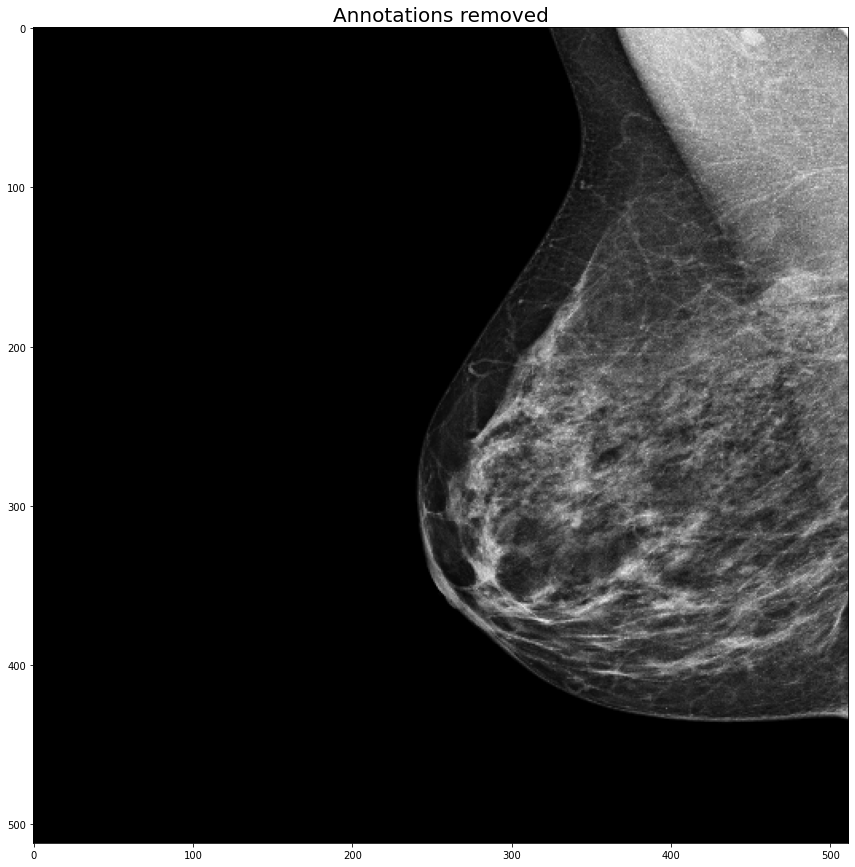

In [8]:
image_no_label = Pipeline._remove_annotation(image)
plt.imshow(image_no_label, cmap="gray")
plt.title("Annotations removed", fontsize=20)
plt.show()

# Remove horizontal or vertical white lines or black lines at top or bottom

Detection of edges

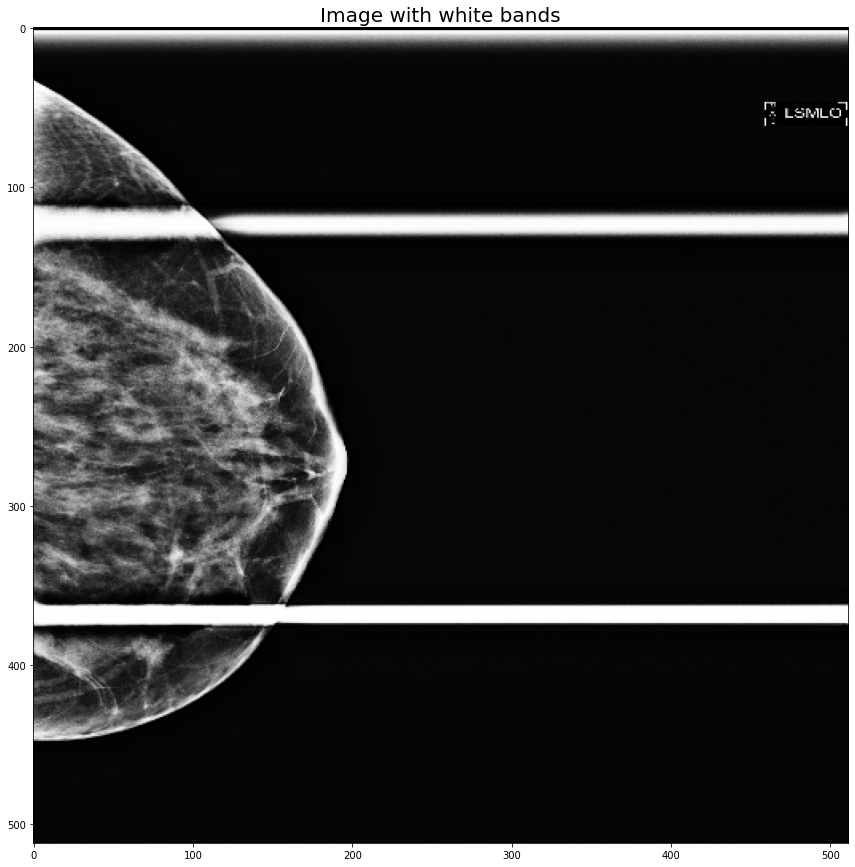

In [9]:
# img = cv2.imread(examples_list_path[-1])
image = cv2.imread(examples_list_path[10])
plt.imshow(image, cmap="gray")
plt.title("Image with white bands", fontsize=20)
plt.show()

In [10]:
img_lines, lines = Pipeline.get_horizontal_lines(image)

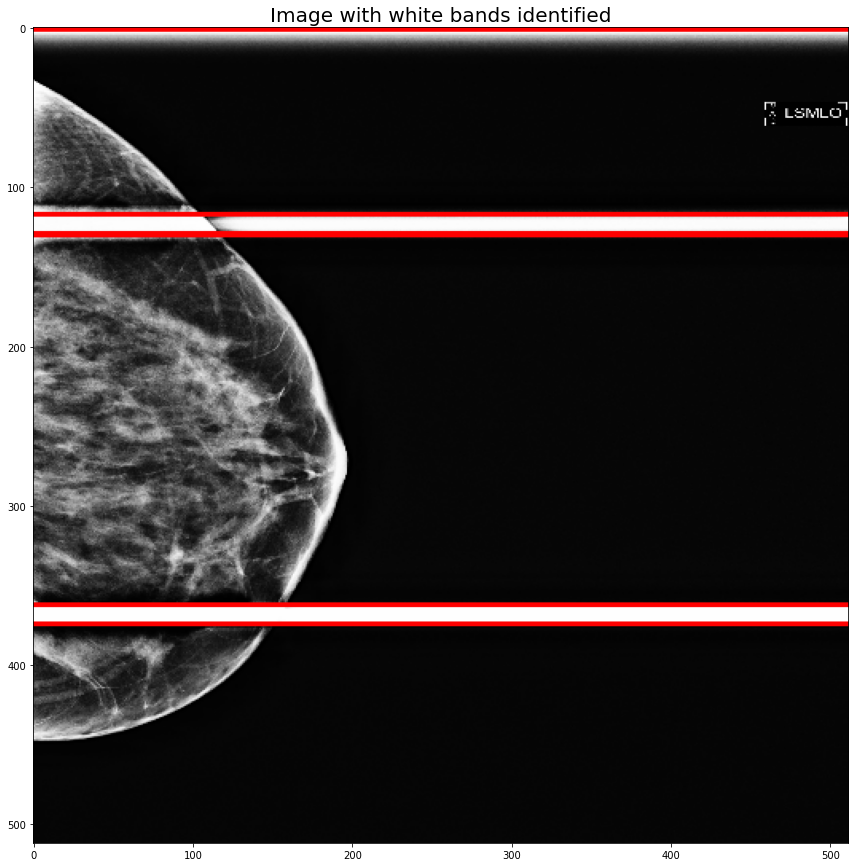

In [11]:
plt.imshow(img_lines, cmap="gray")
plt.title("Image with white bands identified", fontsize=20)
plt.show()

Detection of major horizontal lines (TODO do the same for vertical lines if there are) and TODO keep only 4 lines

__Rectangles have a height of around 10 pixels__

In [12]:
list_images = Pipeline.split_images_lines(image, filtered_lines=lines)

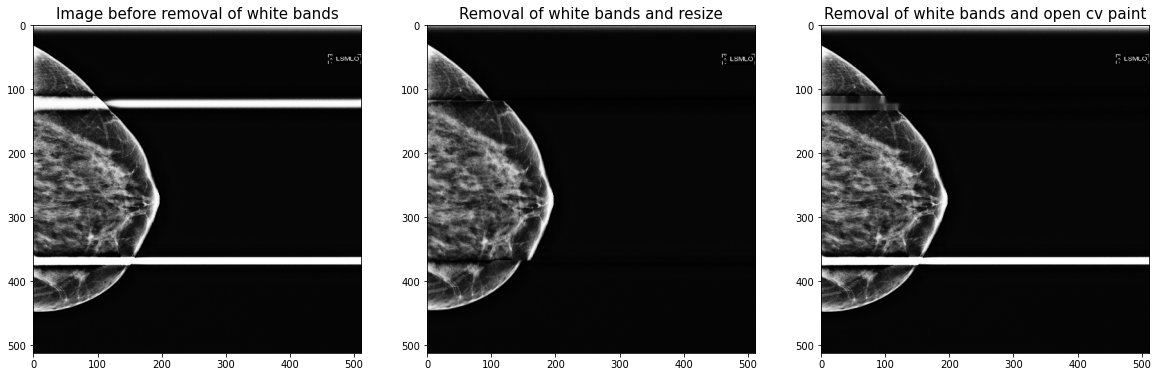

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

ax1.imshow(image)
ax1.set_title("Image before removal of white bands", fontsize=15)

ax2.imshow(
    Pipeline.restore_image(
        image=image,
        list_images=list_images,
        filtered_lines=lines,
        method="delete",
        thresh_low=0.1,
    )
)
ax2.set_title("Removal of white bands and resize", fontsize=15)

ax3.imshow(
    Pipeline.restore_image(
        image=image,
        list_images=list_images,
        filtered_lines=lines,
        method="opencv paint",
        thresh_low=0.1,
    )
)
ax3.set_title("Removal of white bands and open cv paint", fontsize=15)
plt.show()

__TODO: Explore masked ViT to restore white bands__

# Test (for ultra bright images with too bright zones)

__Try to reconstruct with ViT if possible__

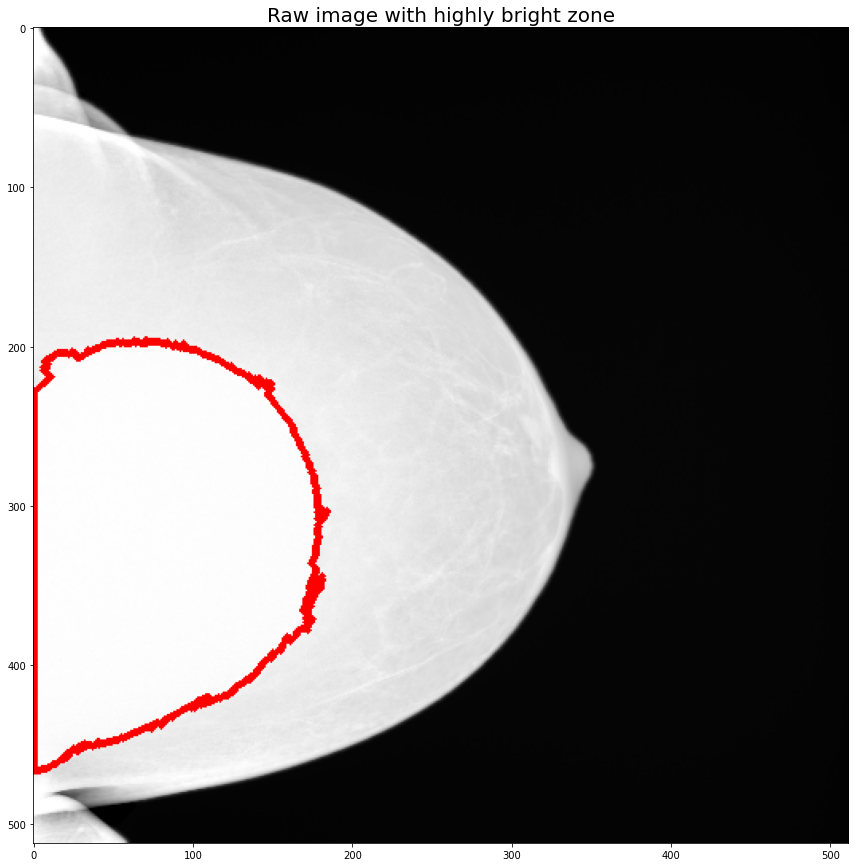

In [14]:
test = cv2.imread(examples_list_path[21])  # 10
test = Pipeline._to_gray(test)
contours = Pipeline.get_contours(test, thresh_low=245)
plt.imshow(Pipeline.draw_contours(contours, test, biggest=True)[0], cmap="gray")
plt.title("Raw image with highly bright zone", fontsize=20)
plt.show()

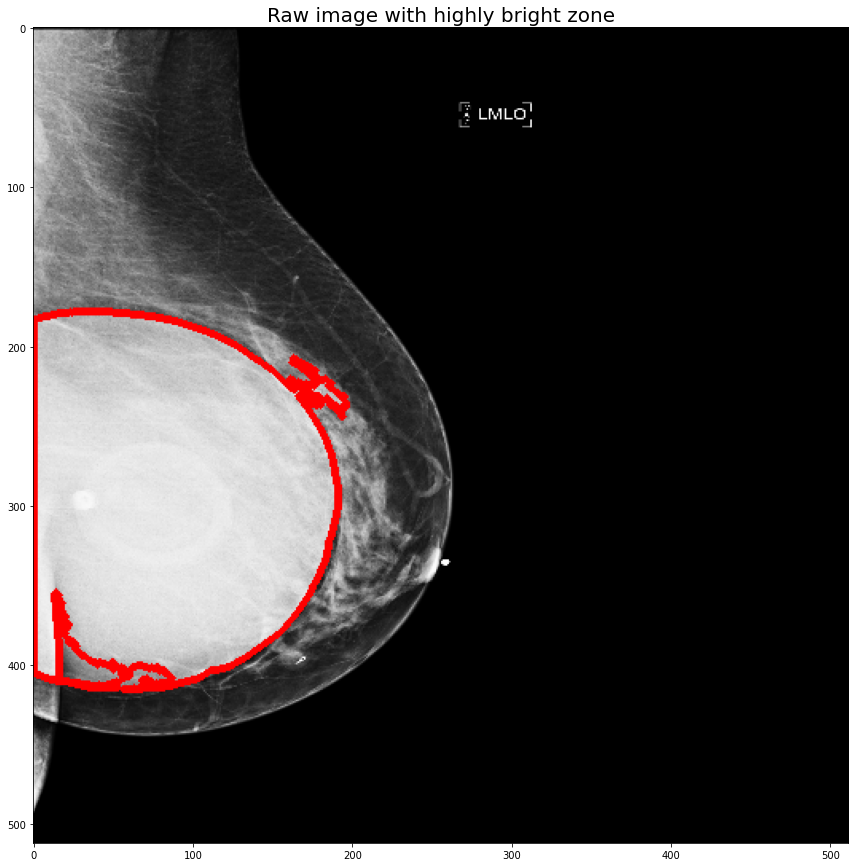

In [15]:
test = cv2.imread(examples_list_path[14])  # 10
test = Pipeline._to_gray(test)
contours = Pipeline.get_contours(test, thresh_low=170)
plt.imshow(Pipeline.draw_contours(contours, test, biggest=True)[0], cmap="gray")
plt.title("Raw image with highly bright zone", fontsize=20)
plt.show()

# Image normalization and enhancement

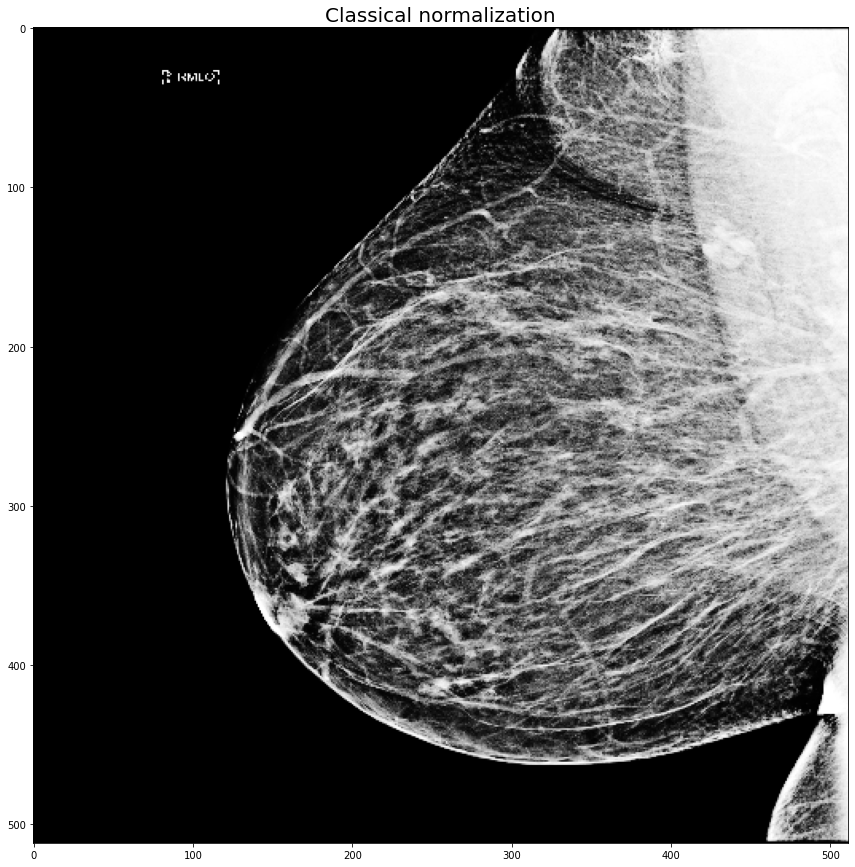

In [17]:
image = cv2.imread(examples_list_path[6])  # 18
image = Pipeline._to_gray(image)
plt.imshow(Pipeline.normalize(image,method = "global"), cmap="gray")
plt.title("Classical normalization", fontsize=20)
plt.show()

__Might to be too harsh to apply a global histogram enhancement__

__With CLAE (cf. https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html)__

__TODO: Apply a mask on the contour for equalization__

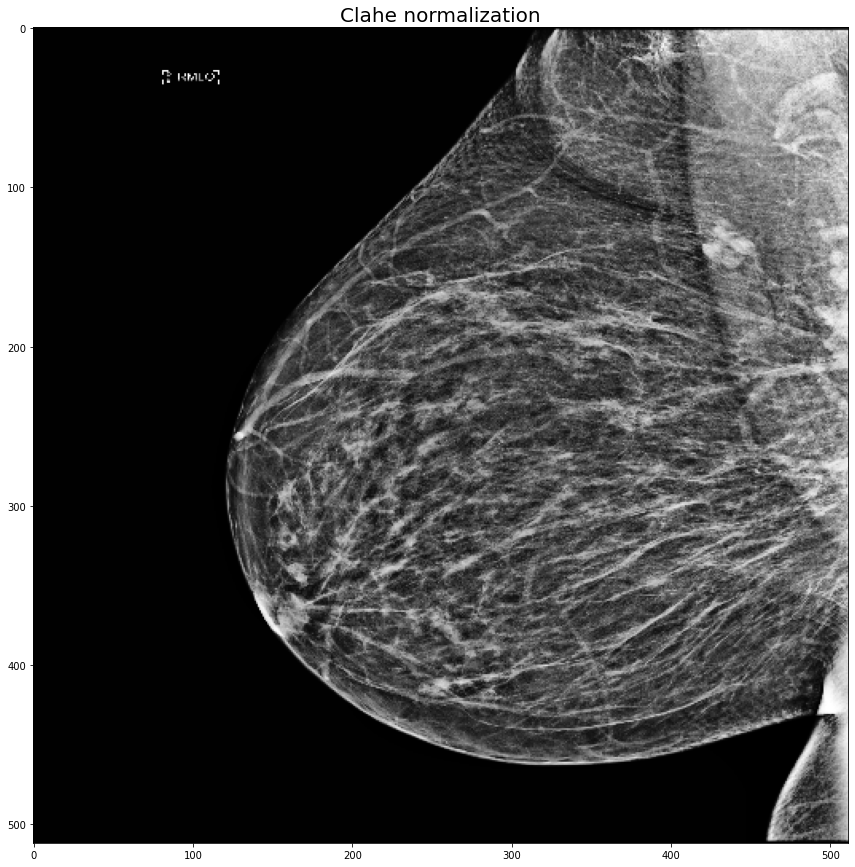

In [19]:
image = cv2.imread(examples_list_path[6])  # 18
image = Pipeline._to_gray(image)
plt.imshow(Pipeline.normalize(image), cmap="gray")
plt.title("Clahe normalization", fontsize=20)
plt.show()

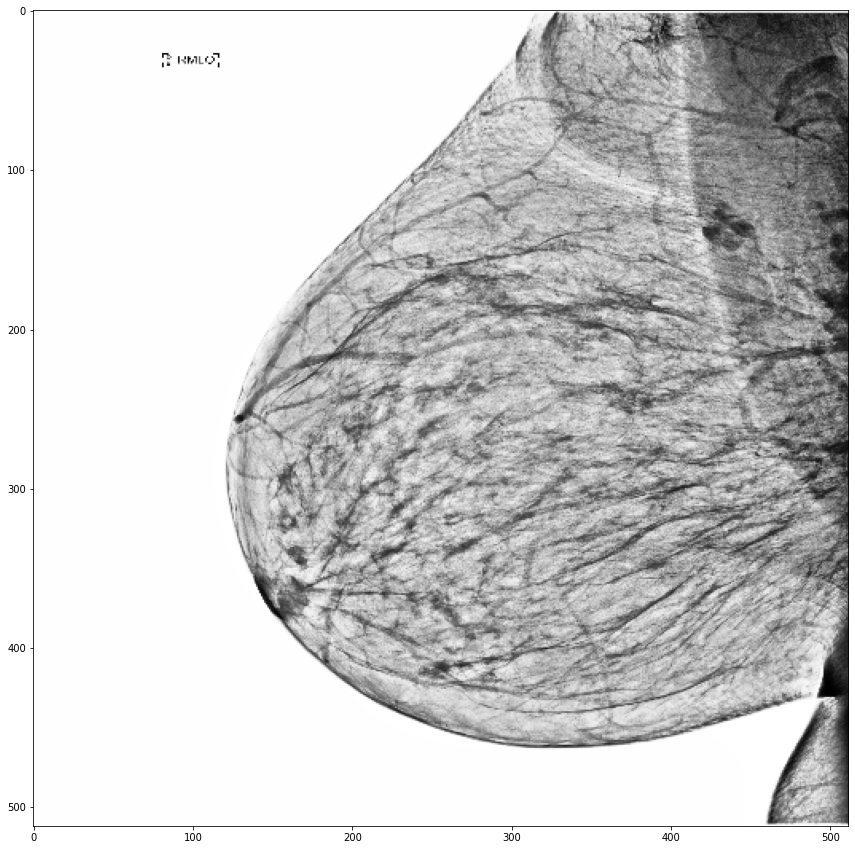

In [91]:
# Do we invert image?
image_reverted = cv2.bitwise_not(cl1)
plt.imshow(image_reverted, cmap="gray")

# Image denoising?

In [55]:
img_denoized = cv2.fastNlMeansDenoising(image_reverted, None, 10, 7, 21)

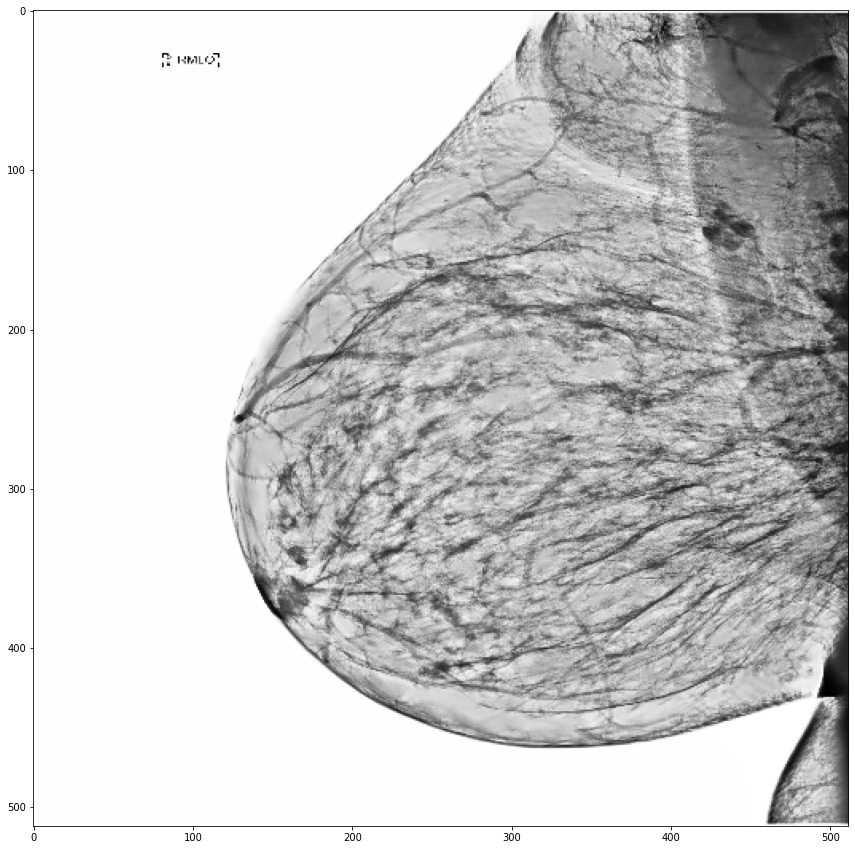

In [56]:
plt.imshow(img_denoized, cmap="gray")

# Background uniformity 

cf.  _Impact of Image Enhancement Module for Analysis of Mammogram Images for Diagnostics of Breast Cancer_

In [82]:
# Bottom hat
# Define the kernel size for the morphological operation
kernel_size = 64

# Create a kernel for the morphological operation
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Perform the morphological bottom hat operation
bottom_hat = cv2.morphologyEx(img_denoized, cv2.MORPH_BLACKHAT, kernel)
bottom_hat = cv2.bitwise_not(bottom_hat)

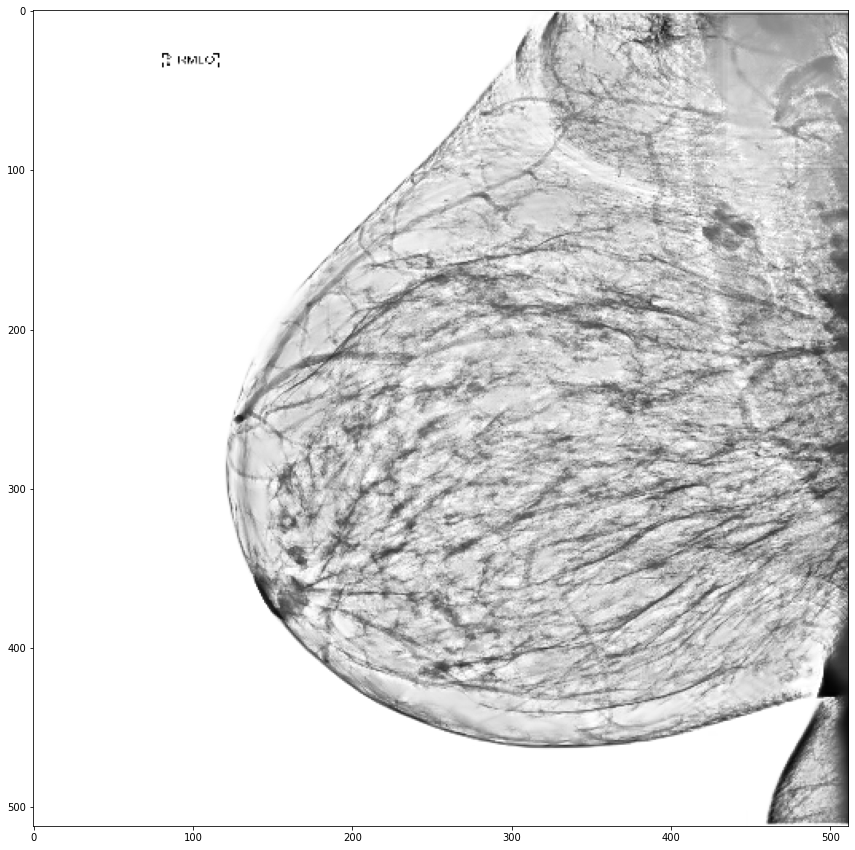

In [83]:
plt.imshow(bottom_hat, cmap="gray")

# Gamma correction?

In [92]:
# Define the gamma correction factor
gamma = 2.2

# Create a look-up table for gamma correction
lut = np.array(
    [((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(0, 256)]
).astype("uint8")

# Apply gamma correction to the image
gamma_corrected = cv2.LUT(bottom_hat, lut)

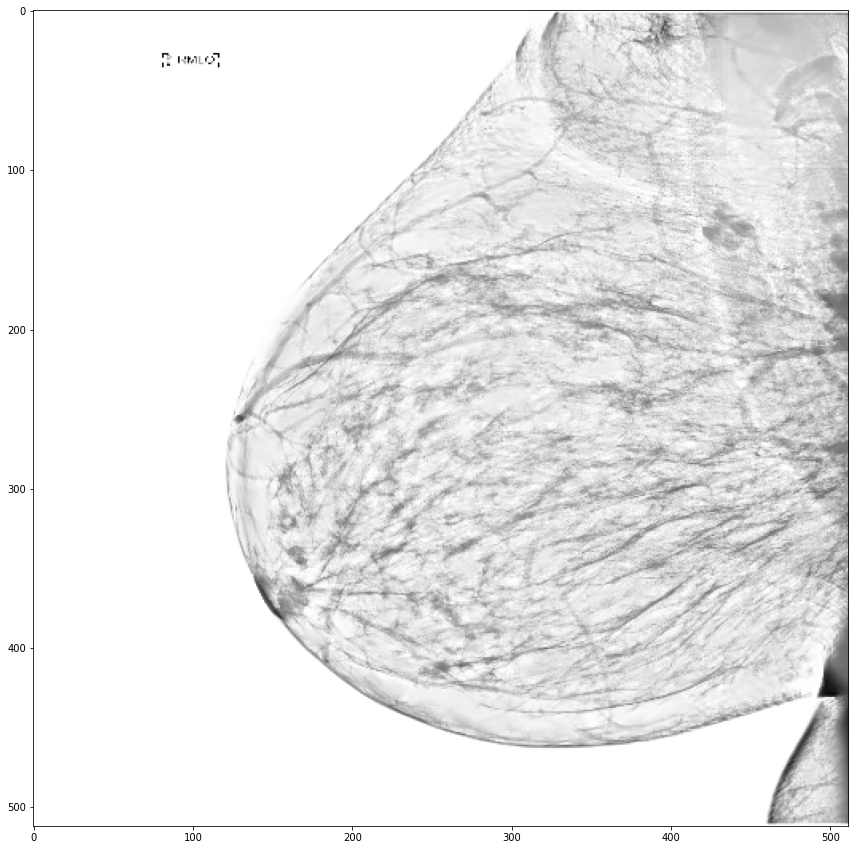

In [93]:
plt.imshow(gamma_corrected, cmap="gray")

# Image sharpening?

# Image normalization?

# Draft not relevant

In [11]:
# Run the probabilistic Hough line detector

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=20)
try:
    if not lines:
        lines = []
except:
    pass
filtered_lines = []
if len(lines) != 0:
    lines = sorted(
        lines,
        key=lambda x: np.sqrt((x[0][0] - x[0][2]) ** 2 + (x[0][1] - x[0][3]) ** 2),
    )
    # Keep only the longest lines
    lines = lines[-min(6, len(lines)) :]

    img_copy = image.copy()
    # Iterate over the lines and draw them on the image
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        if abs(slope) < 0.1:
            x2 = image.shape[1] - 1
            x1 = 0
            line = [[x1, y1, x2, y2]]
            filtered_lines.append(line)
            cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
    if filtered_lines:
        # Initialize the list of images
        images = []
        filtered_lines = sorted(filtered_lines, key=lambda x: x[0][1])
        # Iterate over the lines and crop the image
        y1 = 0
        for line in filtered_lines:
            y2 = line[0][1]
            images.append(image[y1:y2, :])
            y1 = y2

        # Add the final image
        images.append(image[y1:, :])

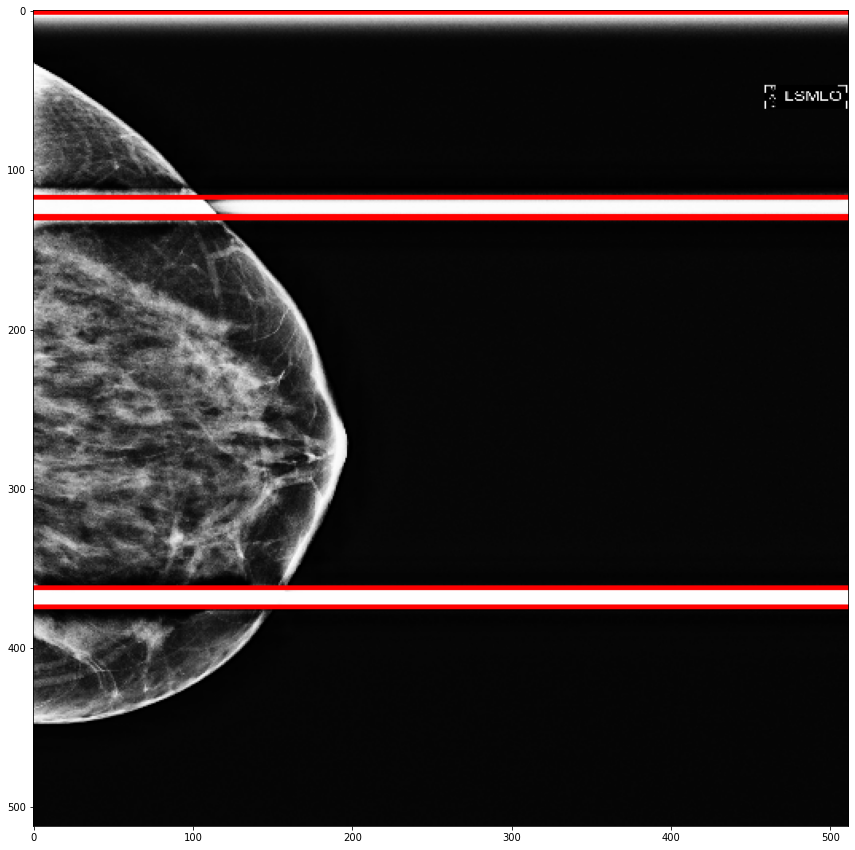

In [12]:
if filtered_lines:
    # Detect main white bands
    plt.imshow(img_copy, cmap="gray")

In [23]:
filtered_lines = lines
images = list_images
filtered_lines = sorted(filtered_lines, key=lambda x: x[0][1])
inpainted_image = image.copy()
if filtered_lines and len(filtered_lines) > 1:

    thresh = 0.1
    indexes = [
        i
        for i, elem in enumerate(images)
        if elem.shape[0] > int(thresh * image.shape[0])
    ]
    zones_to_paint = [
        (filtered_lines[i - 1][0], filtered_lines[i][0])
        for i, elem in enumerate(images)
        if (i not in indexes) and (i - 1 >= 0)
    ]

    images = [elem[4:-4] for i, elem in enumerate(images) if i in indexes]
    images_restore = cv2.resize(np.vstack(images), image.shape[0:2])

    for zone in zones_to_paint:
        # Create a mask for the rectangle
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask[zone[0][1] - 4 : zone[1][1] + 4, 0:512] = 255
        # Inpaint the image
        inpainted_image = cv2.inpaint(inpainted_image, mask, 3, cv2.INPAINT_TELEA)

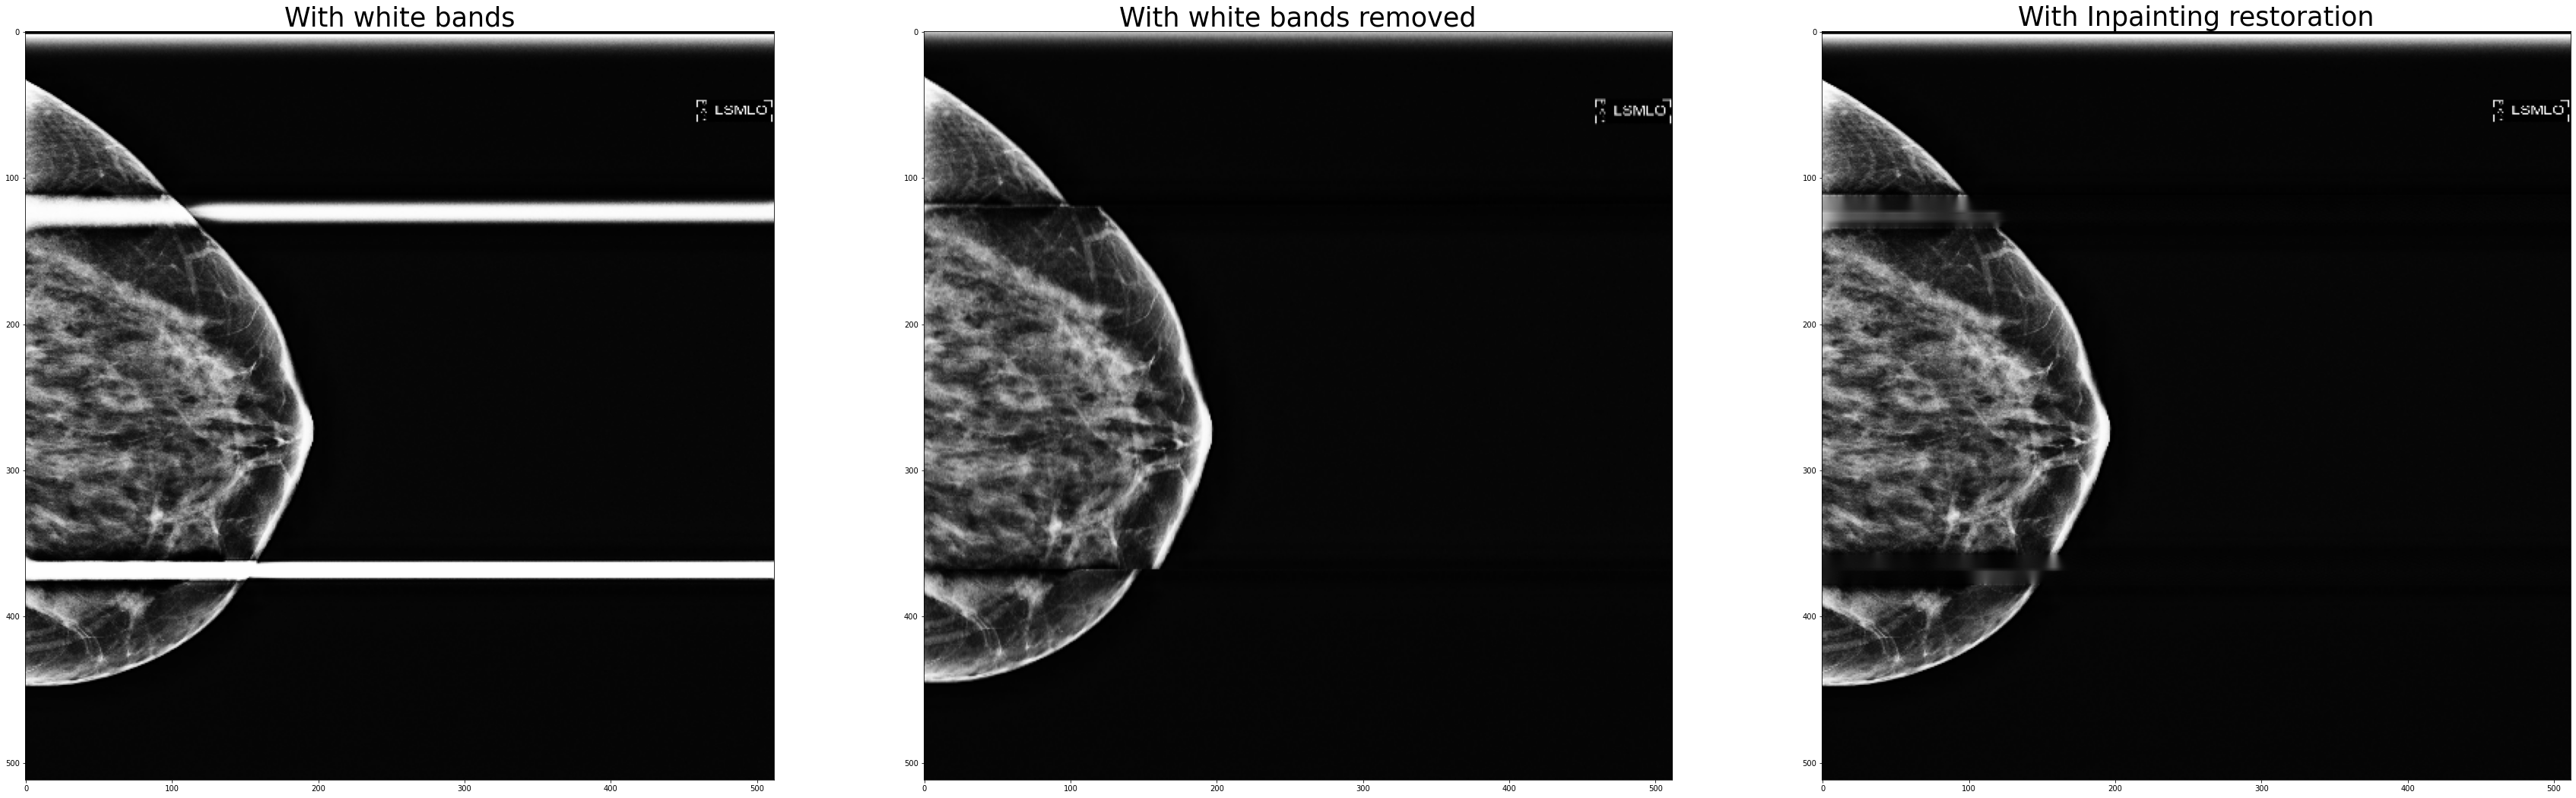

In [20]:
if filtered_lines and len(filtered_lines) > 1:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))
    ax1.imshow(image)
    ax1.set_title("With white bands", fontsize=35)
    ax2.imshow(images_restore)
    ax2.set_title("With white bands removed", fontsize=35)
    ax3.imshow(inpainted_image)
    ax3.set_title("With Inpainting restoration", fontsize=35)
    plt.show()